<a href="https://colab.research.google.com/github/nchadburn/Stat598-FinalProject/blob/main/arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
# finanance data
import yfinance as yf

#visualization
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

#date manipulation
from datetime import datetime
import pandas as pd
import numpy as np

#Autoreg and Arima models
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

# statstical testing, plotting and decompositions
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [60]:
#set variables here
ticker_name = "GOOGL"
start_date = '2022-01-01'
split_date = '2023-01-01'
end_date = '2023-01-01' #none
#set the column we will be analyzing here for the dat set.
column_reference ="Close"
moving_average_list =[2,5,14]
adf_significance_level = .05
periods_to_test = [7, 14, 28,60, 90,180, 365]

In [61]:
ticker = yf.Ticker(ticker_name)
ticker_info = ticker.info

ticker_details = {
    "Name": ticker_info.get("shortName"),
    "Sector": ticker_info.get("sector"),
    "Industry": ticker_info.get("industry"),
    "Full Time Employees": ticker_info.get("fullTimeEmployees"),
    "Business Summary": ticker_info.get("longBusinessSummary"),
}

ticker_details

{'Name': 'Alphabet Inc.',
 'Sector': 'Communication Services',
 'Industry': 'Internet Content & Information',
 'Full Time Employees': 182381,
 'Business Summary': 'Alphabet Inc. offers various products and platforms in the United States, Europe, the Middle East, Africa, the Asia-Pacific, Canada, and Latin America. It operates through Google Services, Google Cloud, and Other Bets segments. The Google Services segment provides products and services, including ads, Android, Chrome, hardware, Gmail, Google Drive, Google Maps, Google Photos, Google Play, Search, and YouTube. It is also involved in the sale of apps and in-app purchases and digital content in the Google Play store; and Fitbit wearable devices, Google Nest home products, Pixel phones, and other devices, as well as in the provision of YouTube non-advertising services. The Google Cloud segment offers infrastructure, cybersecurity, data, analytics, AI, and machine learning, and other services; Google Workspace that include cloud-

In [79]:
df_history = ticker.history(start=start_date, end=end_date, interval='1d')

In [80]:
df_history['data'] = df_history[column_reference].copy()

df_train = df_history.loc[df_history.index < split_date].copy()
df_validation = df_history.loc[df_history.index >= split_date].copy()

print(df_train.shape)
print(df_validation.shape)
df_train.columns


(251, 8)
(0, 8)


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'data'],
      dtype='object')

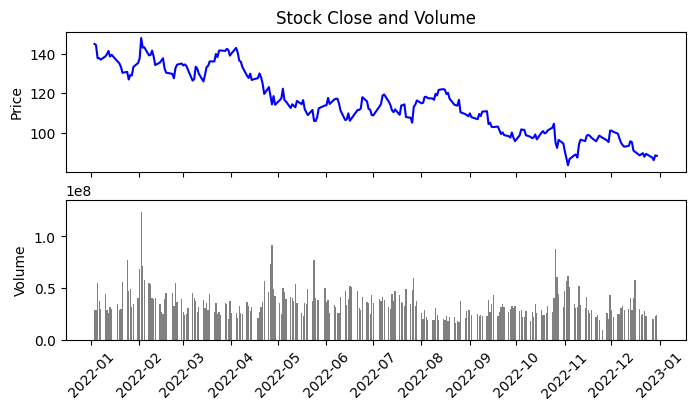

In [81]:
#drawing volumne, close and dividens

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,4))

ax1.plot(df_train.index, df_train[column_reference], color='blue')
ax1.set_title(f'Stock {column_reference} and Volume')
ax1.set_ylabel('Price')


ax2.bar(df_train.index, df_train['Volume'], color='gray')
ax2.set_ylabel('Volume')
max_volume = df_train['Volume'].max()
ax2.set_ylim(0, max_volume * 1.1)

# drawing a green line for dividend
for date, row in df_train.iterrows():
    if row['Dividends'] > 0:
        ax1.axvline(x=date, color='green', linestyle='--', alpha=0.7)
        ax2.axvline(x=date, color='green', linestyle='--', alpha=0.7)


ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=45)
plt.show()


At this point we will start some general analysis, which we can use for benchmarking. We will use Moving Averaga MA.

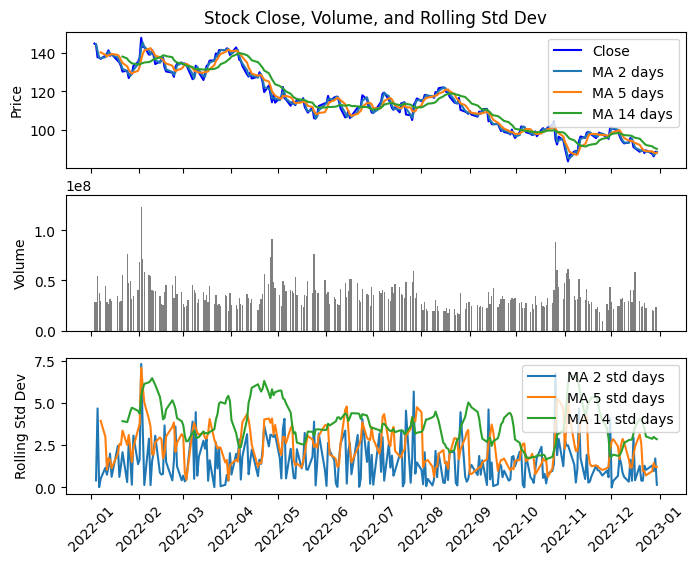

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,6))

ax1.plot(df_train.index, df_train[column_reference], color='blue', label=column_reference)
ax1.set_title(f'Stock {column_reference}, Volume, and Rolling Std Dev')
ax1.set_ylabel('Price')

for ma in moving_average_list:
    df_train[f'MA_{ma}'] = df_train[column_reference].rolling(window=ma).mean()
    ax1.plot(df_train.index, df_train[f'MA_{ma}'], label=f'MA {ma} days')


ax2.bar(df_train.index, df_train['Volume'], color='gray')
ax2.set_ylabel('Volume')
max_volume = df_train['Volume'].max()
ax2.set_ylim(0, max_volume * 1.1)

for ma in moving_average_list:
    df_train[f'MA_{ma}_std'] = df_train[column_reference].rolling(window=ma).std()
    ax3.plot(df_train.index, df_train[f'MA_{ma}_std'], label=f'MA {ma} std days')


ax3.set_ylabel('Rolling Std Dev')

# Drawing dividend lines on all subplots
for date, row in df_train.iterrows():
    if row['Dividends'] > 0:
        ax1.axvline(x=date, color='green', linestyle='--', alpha=0.7)
        ax2.axvline(x=date, color='green', linestyle='--', alpha=0.7)
        ax3.axvline(x=date, color='green', linestyle='--', alpha=0.7)


ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())


ax1.legend()
ax3.legend()

plt.xticks(rotation=45)
plt.show()


From these charts wse can see that forecasting is not simple as we have non stationary charts

ADF Statistic: -1.5186647576004457
p-value: 0.5242587767632091
Number of Lags Used: 0
Number of Observations Used: 250
Critical Values:
  1%: -3.456780859712
  5%: -2.8731715065600003
  10%: -2.572968544
p-value is greater than or equal to 0.05, so the series is likely non-stationary.


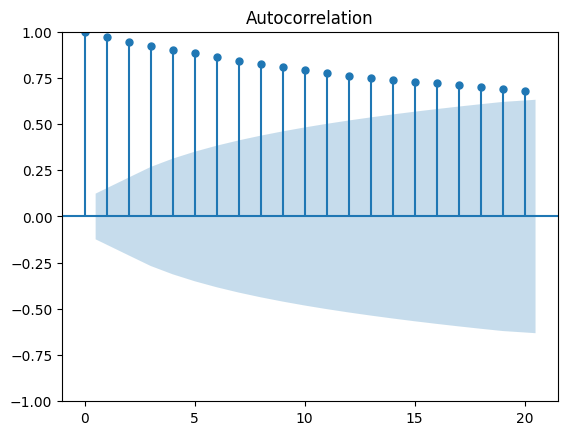

In [83]:
def run_ADF(data):
    adf_statistic, p_value, num_lags, num_obs, critical_values, icbest = adfuller(data)
    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)
    print("Number of Lags Used:", num_lags)
    print("Number of Observations Used:", num_obs)
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f'  {key}: {value}')

    if p_value < adf_significance_level:
        print(f"p-value is less than {adf_significance_level}, so the series is likely stationary.")
    else:
        print(f"p-value is greater than or equal to {adf_significance_level}, so the series is likely non-stationary.")
    return p_value

run_ADF(df_train[column_reference])
plot_acf(df_train[column_reference], lags=20);

As expected our data is not stationary, so we will apply a few transformations to try to get it stationary.

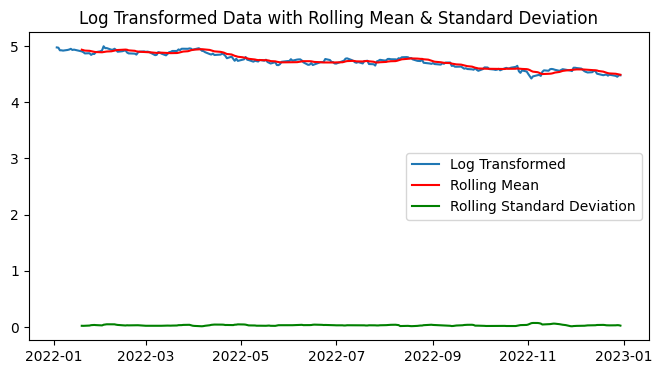

ADF Statistic: -1.3295464118936242
p-value: 0.6155487546775984
Number of Lags Used: 0
Number of Observations Used: 250
Critical Values:
  1%: -3.456780859712
  5%: -2.8731715065600003
  10%: -2.572968544
p-value is greater than or equal to 0.05, so the series is likely non-stationary.


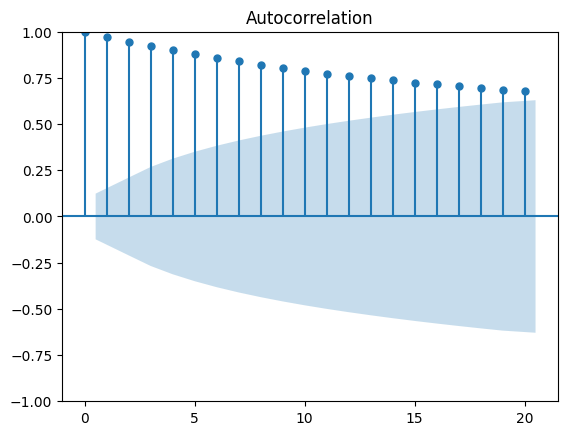

In [84]:
#transform data
df_log = np.log(df_train[column_reference])

rolling_mean = df_log.rolling(window=12).mean()
rolling_std = df_log.rolling(window=12).std()

plt.figure(figsize=(8,4))
plt.plot(df_log, label='Log Transformed')
plt.plot(rolling_mean, color='r', label='Rolling Mean')
plt.plot(rolling_std, color='g', label='Rolling Standard Deviation')
plt.legend()
plt.title('Log Transformed Data with Rolling Mean & Standard Deviation')
plt.show()

run_ADF(df_log)
plot_acf(df_log, lags=20);

Still unstationary, but our variance looks ALOT better!.


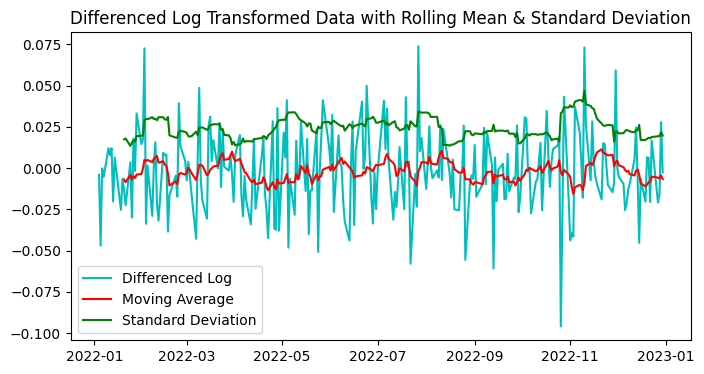

ADF Statistic: -16.32269703830428
p-value: 3.116294939022033e-29
Number of Lags Used: 0
Number of Observations Used: 249
Critical Values:
  1%: -3.4568881317725864
  5%: -2.8732185133016057
  10%: -2.5729936189738876
p-value is less than 0.05, so the series is likely stationary.


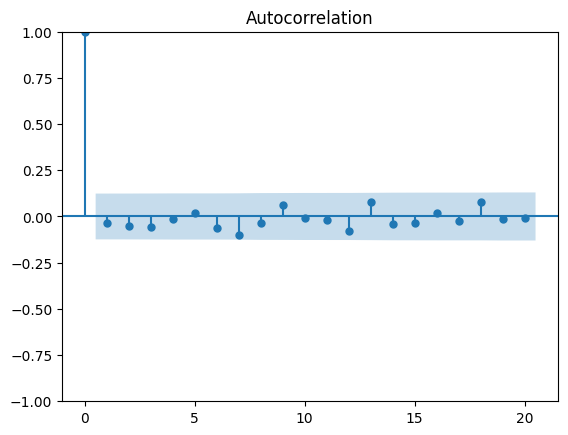

In [85]:

# Differencing log-transformed data by one period, this helps us check for random walk
df_shift = df_log - df_log.shift(periods=1)

# Calculating rolling mean and standard deviation
MAvg_shift = df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()


plt.figure(figsize=(8,4))
plt.plot(df_shift, color='c', label='Differenced Log')
plt.plot(MAvg_shift, color='red', label='Moving Average')
plt.plot(MStd_shift, color='green', label='Standard Deviation')
plt.legend()
plt.title('Differenced Log Transformed Data with Rolling Mean & Standard Deviation')
plt.show()


df_shift.dropna(inplace=True)
run_ADF(df_shift)
plot_acf(df_shift, lags=20);


Notice our data is now stationary, so we can now move on to other analysis.

In [87]:
mean = np.mean(df_train[column_reference])

df_train.loc[:, 'pred_mean'] = mean

df_train.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,data,MA_2,MA_5,MA_14,MA_2_std,MA_5_std,MA_14_std,pred_mean
Date,,,,,,,,,,,,,,,
2022-01-03 00:00:00-05:00,145.054993,145.850998,143.712997,144.991501,28646000,0.0,0.0,144.991501,NaN,NaN,NaN,NaN,NaN,NaN,114.760371
2022-01-04 00:00:00-05:00,145.395996,146.485001,143.716507,144.399506,28400000,0.0,0.0,144.399506,144.695503,NaN,NaN,0.418604,NaN,NaN,114.760371
2022-01-05 00:00:00-05:00,144.419998,144.499496,137.688004,137.774994,54618000,0.0,0.0,137.774994,141.087250,NaN,NaN,4.684237,NaN,NaN,114.760371
2022-01-06 00:00:00-05:00,136.998505,139.940002,136.558502,137.747498,37348000,0.0,0.0,137.747498,137.761246,NaN,NaN,0.019443,NaN,NaN,114.760371
2022-01-07 00:00:00-05:00,138.145493,138.448502,135.766495,137.016998,29760000,0.0,0.0,137.016998,137.382248,140.386099,NaN,0.516541,3.951205,NaN,114.760371


In [90]:
last_value = df_train[column_reference].iloc[-1]
df_train['pred_last'] = last_value
df_train.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,data,MA_2,MA_5,MA_14,MA_2_std,MA_5_std,MA_14_std,pred_mean,pred_last
Date,,,,,,,,,,,,,,,,
2022-01-03 00:00:00-05:00,145.054993,145.850998,143.712997,144.991501,28646000,0.0,0.0,144.991501,NaN,NaN,NaN,NaN,NaN,NaN,114.760371,88.230003
2022-01-04 00:00:00-05:00,145.395996,146.485001,143.716507,144.399506,28400000,0.0,0.0,144.399506,144.695503,NaN,NaN,0.418604,NaN,NaN,114.760371,88.230003
2022-01-05 00:00:00-05:00,144.419998,144.499496,137.688004,137.774994,54618000,0.0,0.0,137.774994,141.087250,NaN,NaN,4.684237,NaN,NaN,114.760371,88.230003
2022-01-06 00:00:00-05:00,136.998505,139.940002,136.558502,137.747498,37348000,0.0,0.0,137.747498,137.761246,NaN,NaN,0.019443,NaN,NaN,114.760371,88.230003
2022-01-07 00:00:00-05:00,138.145493,138.448502,135.766495,137.016998,29760000,0.0,0.0,137.016998,137.382248,140.386099,NaN,0.516541,3.951205,NaN,114.760371,88.230003


In [105]:
initial_value = df_train[column_reference].iloc[0]
final_value = df_train[column_reference].iloc[-1]

drift = (final_value - initial_value) / (len(df_train[column_reference]) - 1)
df_train.loc[:, 'pred_drift'] = drift *df_train[column_reference]



In [106]:
mse_mean = mean_squared_error(df_train[column_reference], df_train['pred_mean'])
mse_last = mean_squared_error(df_train[column_reference], df_train['pred_last'])
mse_drift = mean_squared_error(df_train[column_reference], df_train['pred_drift'])

print(mse_mean, mse_last,mse_drift)

258.47054136727434 962.3309256191886 20218.381038836127


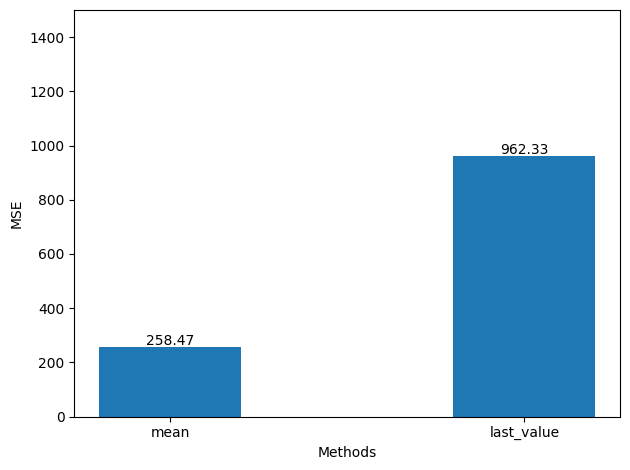

In [108]:
fig, ax = plt.subplots()

x = ['mean', 'last_value']
y = [mse_mean, mse_last]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 1500)

for index, value in enumerate(y):
    plt.text(x=index, y=value+5, s=str(round(value, 2)), ha='center')

plt.tight_layout()



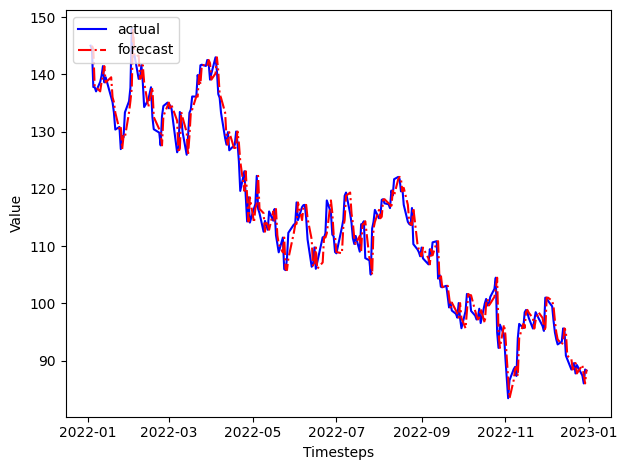

In [100]:
df_train['offset_column'] = df_train[column_reference].shift(1)
fig, ax = plt.subplots()

ax.plot(df_train[column_reference], 'b-', label='actual')
ax.plot(df_train['offset_column'], 'r-.', label='forecast')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

plt.show()

In [103]:
mse_one_step = mean_squared_error(df_train[column_reference].iloc[1:], df_train['offset_column'].iloc[1:])
mse_one_step

7.731875995660899

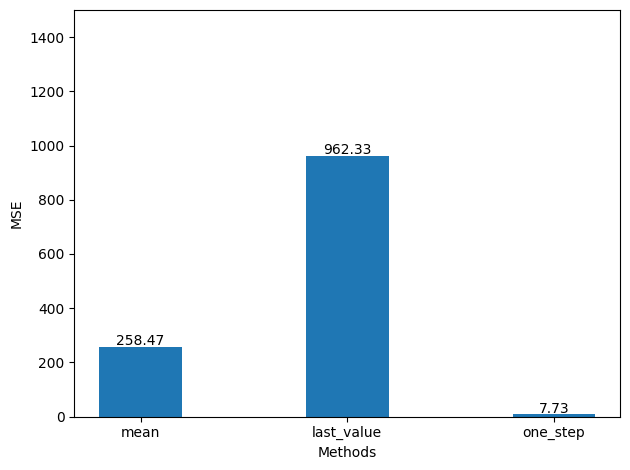

In [104]:
fig, ax = plt.subplots()

x = ['mean', 'last_value','one_step']
y = [mse_mean, mse_last,mse_one_step ]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 1500)

for index, value in enumerate(y):
    plt.text(x=index, y=value+5, s=str(round(value, 2)), ha='center')

plt.tight_layout()

